# COIL-20 dataset

The COIL-20 dataset consists of gray-scale images of 20 objects. Each object was rotated, and an image was taken for each 5 degrees of rotation (so, 72 images per object). One might hope, therefore, to find 20 clusters, one per object. For more detail, see [the Columbia Imaging and Vision Laboratory page](https://cave.cs.columbia.edu/repository/COIL-20) for this dataset.

We cluster the COIL-20 dataset with Persistable. Using the interactive mode, we explore the basic cluster structure in the data, and find parameters that lead to a clustering that match the labels well.

Importantly, we pre-process the data using PCA, following [Leland McInnes' notebook Clustering evaluation on high dimensional data](https://gist.github.com/lmcinnes).

In [1]:
import persistable
import numpy as np
import pandas as pd
import json
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

## Load the data

Using code from [McInnes' notebook Clustering evaluation on high dimensional data](https://gist.github.com/lmcinnes).

In [2]:
import requests
import zipfile
import imageio
import os
import re

In [3]:
if not os.path.isfile('coil20.zip'):
    results = requests.get('http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-20/coil-20-proc.zip')
    with open("coil20.zip", "wb") as code:
        code.write(results.content)

In [4]:
images_zip = zipfile.ZipFile('coil20.zip')
mylist = images_zip.namelist()
r = re.compile(".*\.png$")
filelist = list(filter(r.match, mylist))

In [5]:
if not os.path.isfile('coil-20-proc/obj10__1.png'):
    !unzip coil20.zip

Archive:  coil20.zip
 extracting: coil-20-proc/obj10__1.png  
 extracting: coil-20-proc/obj10__10.png  
 extracting: coil-20-proc/obj10__11.png  
 extracting: coil-20-proc/obj10__12.png  
 extracting: coil-20-proc/obj10__13.png  
 extracting: coil-20-proc/obj10__14.png  
 extracting: coil-20-proc/obj10__15.png  
 extracting: coil-20-proc/obj10__16.png  
 extracting: coil-20-proc/obj10__17.png  
 extracting: coil-20-proc/obj10__18.png  
 extracting: coil-20-proc/obj10__19.png  
 extracting: coil-20-proc/obj10__2.png  
 extracting: coil-20-proc/obj10__20.png  
 extracting: coil-20-proc/obj10__21.png  
 extracting: coil-20-proc/obj10__22.png  
 extracting: coil-20-proc/obj10__23.png  
 extracting: coil-20-proc/obj10__24.png  
 extracting: coil-20-proc/obj10__25.png  
 extracting: coil-20-proc/obj10__26.png  
 extracting: coil-20-proc/obj10__27.png  
 extracting: coil-20-proc/obj10__28.png  
 extracting: coil-20-proc/obj10__29.png  
 extracting: coil-20-proc/obj10__3.png  
 extracting: coi

In [6]:
coil_feature_vectors = []
for filename in filelist:
    im = imageio.imread(filename)
    coil_feature_vectors.append(im.flatten())
coil_20_data = np.asarray(coil_feature_vectors)
coil_20_target = pd.Series(filelist).str.extract("obj([0-9]+)", expand=False).values.astype(np.int32)
raw_coil = coil_20_data.astype(np.float64)

## Apply PCA to reduce the dimensionality of the data

In [7]:
pca_coil = PCA(n_components=200).fit_transform(raw_coil)

## Launch an instance of the Persistable interactive mode with pre-chosen settings

We played around with the parameters of the Component Counting Function and Prominence Vineyard to find settings that do a nice job of identifying cluster structure in COIL-20. Feel free to adjust these settings to see the data from different points of view.

### Basic usage of the Persistable interactive mode

- Run the cell below to open the graphical user interface.
- To see the Component Counting Function, click "Compute".
- To see the Prominence Vineyard, in the box "Interactive inputs selection", choose "Family of lines". Now, one sees the two chosen lines that determine the Prominence Vineyard. Next, click "Compute" under "Prominence Vineyard".
- To get a clustering, in the box "Parameter selection", choose "On".
- To get a clustering that matches the COIL-20 labels reasonably well, select Line number 7 and Gap number 19. Then click "Choose parameter".
- To get the labels for this clustering, run the cell below the graphical user interface.

In [8]:
# load a state dictionary to pass to start_ui
with open('COIL-20-state.json', 'r') as fp:
    state = json.load(fp)

# create Persistable object
p = persistable.Persistable(pca_coil, n_neighbors='all')

# start UI
pi = persistable.PersistableInteractive(p)
port = pi.start_ui(ui_state=state, jupyter_mode='inline')

In [9]:
cluster_labels = pi.cluster()

## Comparing with COIL-20 labels

If we select Gap 19, we get a clustering with 19 clusters, which matches the dataset labels fairly well.

In [10]:
target_labels = coil_20_target

# get indices of points clustered by Persistable
clustered_points = (cluster_labels >= 0)

# print adjusted rand index, and percentage of data points clustered
ari = adjusted_rand_score(target_labels[clustered_points], cluster_labels[clustered_points])
pct_clustered = (np.sum(clustered_points) / target_labels.shape[0])
print('adjusted rand index: ' + str(ari))
print('percentage of data points clustered: ' + str(pct_clustered))

# print confusion matrix

# re-index the cluster labels, since the target labels start from 1
reindexed_cluster_labels = cluster_labels[clustered_points] + 1

print('Confusion matrix:')
print(confusion_matrix(target_labels[clustered_points], reindexed_cluster_labels))

adjusted rand index: 0.8584483745804955
percentage of data points clustered: 0.9673611111111111
Confusion matrix:
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 72  0]
 [16 19 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 62  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 72  0  0  0  0]
 [ 0  0  0  0  0  0  0 67  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 59  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 72  0  0  0  0  0  0  0  0  0]
 [72  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 70  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 72  0  0  0  0  0  0  0]
 [ 0  0  0 72  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 72  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 72  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 72  0  0  0  0  0]
 [ 0

### Interpretation

Inspecting the confusion matrix, we see that the objects with labels 3,6, and 19 have all been clustered together. And, the object with label 2 has been broken up into three clusters, and some data points are clustered with object 8.

Let's look at some data points to see what these objects are.

In [11]:
from IPython.display import Image, display

We first display one image each of objects 3,6, and 19. All of them are toy cars.

Object 3


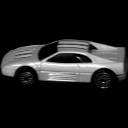

Object 6


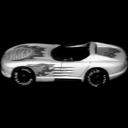

Object 19


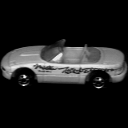

In [12]:
image_samples = [(3,'coil-20-proc/obj3__0.png'), 
                 (6,'coil-20-proc/obj6__0.png'), 
                 (19,'coil-20-proc/obj19__0.png')]

for label, image in image_samples:
    print('Object ' + str(label))
    display(Image(filename=image))

Now we display one image each of objects 2 and 8.

Object 2


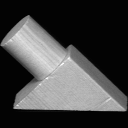

Object 8


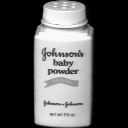

In [13]:
image_samples = [(2,'coil-20-proc/obj2__0.png'), 
                 (8,'coil-20-proc/obj8__0.png')]

for label, image in image_samples:
    print('Object ' + str(label))
    display(Image(filename=image))

If we rotate the objects through 90 degrees, they do indeed look similar.

Object 2


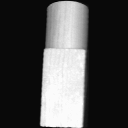

Object 8


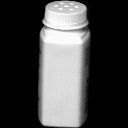

In [14]:
image_samples = [(2,'coil-20-proc/obj2__18.png'), 
                 (8,'coil-20-proc/obj8__18.png')]

for label, image in image_samples:
    print('Object ' + str(label))
    display(Image(filename=image))